In [1]:
import numpy as np
import pandas as pd

#load the GBPUSD_BID dataset
df = pd.read_csv(r'C:\Users\alexm\FX_project\2024_YTD\GBPUSD_BID_15.06.2024_YTD.csv')

# reformat Local time variable as a datetime
from datetime import datetime

df['Date'] = df['Local time'].str[6:10] +'-'+ df['Local time'].str[3:5] +'-'+ df['Local time'].str[0:2]
df['Date'] = pd.to_datetime(df['Date'])

# remove lines where Volume = 0
filtered_df = df[df['Volume'] != 0]
filtered_df['Index'] = range(0,119)

# normalise volume
vol_std = filtered_df[['Volume']].std()
vol_mean = filtered_df[['Volume']].mean()

filtered_df[['Volume']] = (filtered_df[['Volume']] - vol_mean) / vol_std

filtered_df.head()

C:\Users\alexm\AppData\Local\Temp\ipykernel_16292\2666311723.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Index'] = range(0,119)
C:\Users\alexm\AppData\Local\Temp\ipykernel_16292\2666311723.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['Volume']] = (filtered_df[['Volume']] - vol_mean) / vol_std


,Local time,Open,High,Low,Close,Volume,Index,Date
1,01.01.2024 22:00:00.000 GMT-0000,1.27184,1.27596,1.26105,1.26149,1.479164,0,2024-01-01
2,02.01.2024 22:00:00.000 GMT-0000,1.26149,1.26761,1.26139,1.26635,2.172674,1,2024-01-02
3,03.01.2024 22:00:00.000 GMT-0000,1.26629,1.27296,1.26565,1.26808,1.262317,2,2024-01-03
4,04.01.2024 22:00:00.000 GMT-0000,1.26808,1.27707,1.26106,1.27173,2.642993,3,2024-01-04
7,07.01.2024 22:00:00.000 GMT-0000,1.27018,1.27668,1.26729,1.27469,0.068338,4,2024-01-07


In [2]:
# convert filtered_df to array
data = np.array(filtered_df[['Volume', 'Close']])

# calculate pearsons correlation with an exogenous feature (volume in this case)
corr = np.corrcoef(data[:,0], data[:,1])
corr[0,1]

-0.04533765152578921

In [15]:
# check the correlation with the log of the time series
log_data = np.log(data)

log_corr = np.corrcoef(log_data[:,0], log_data[:,1])
print(log_corr[0,1])
log_data[0:10,]

# issue with using log of the normalised volume since some values are -ve. Only use this for non-log volumes 
# looks like the varialble i'm currently using is not an driver of fx rates in this dataset, contrary to technical analysis

nan


C:\Users\alexm\AppData\Local\Temp\ipykernel_17424\1991030783.py:2: RuntimeWarning: invalid value encountered in log
  log_data = np.log(data)


array([[ 0.39147708,  0.23229356],
       [ 0.77595866,  0.23613875],
       [ 0.23294897,  0.23750395],
       [ 0.9719119 ,  0.24037818],
       [-2.68328437,  0.24270301],
       [-1.76803922,  0.23970957],
       [        nan,  0.24231068],
       [ 1.06996978,  0.24359695],
       [ 0.62046851,  0.24273439],
       [-0.63583628,  0.24103848]])

In [5]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest

# normality test
stat, p = normaltest(data[:,1])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=7.944, p=0.019
Sample does not look Gaussian (reject H0)


In [7]:
# Spearman rank correlation
from scipy.stats import spearmanr

rho, p = spearmanr(data[:,0], data[:,1])

print(rho)
print(p)

# indicates a negative correlation as per pearson's but with p value > 0.05 it is not statistically significant

-0.12796322441728114
0.16547579323308845


(array([ 2.,  0.,  0.,  5.,  2.,  3.,  4.,  5.,  6.,  8.,  9.,  9., 10.,
        14., 14., 13.,  5.,  6.,  3.,  1.]),
 array([1.23485  , 1.2373815, 1.239913 , 1.2424445, 1.244976 , 1.2475075,
        1.250039 , 1.2525705, 1.255102 , 1.2576335, 1.260165 , 1.2626965,
        1.265228 , 1.2677595, 1.270291 , 1.2728225, 1.275354 , 1.2778855,
        1.280417 , 1.2829485, 1.28548  ]),
 <BarContainer object of 20 artists>)

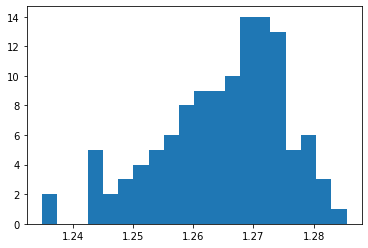

In [11]:
# check the distribution shape
import matplotlib.pyplot as plt

fig = plt.figure()
plt.hist(data[:,1], bins=20)


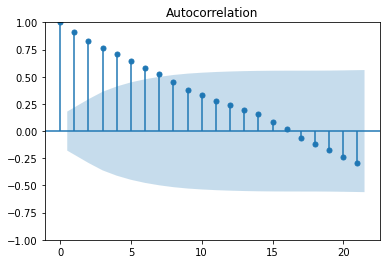

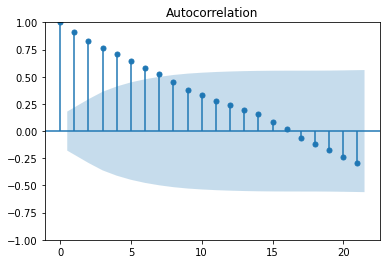

In [9]:
# autocorrelations
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

# calculate autocorrelations and confidence interval with significance alpha
plot_acf(filtered_df[['Close']], alpha = 0.05)

# this shows there is some correlation at 5% significance up to 7 trading days prior.
# short run, there is +ve correlation and longer this reverts to -ve. This is an indicator of non-staionary data...
# ..., trending and also some level of mean reversion, typical of financial markets
# no seasonality is present yet but we could use this analysis for longer times series
# conclusion is there is a lot of noise in the data but also some structure. we should look into denoising

C:\Users\alexm\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


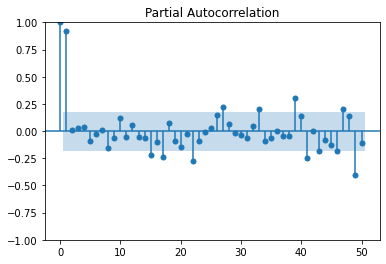

In [10]:
# partial autocorrelations
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(log_data[:,1], lags=50)
pyplot.show()

# here we see a lag of 2 has a large +ve correlation with some other smaller significance in longer lags
# some of this will be due to the size of the sample so will need to look at this further when larger datasets are used
# possible that some seasonality is inherent in the data.